# Uvod #

U ovoj vježbi naučit ćete kako poboljšati rezultate treninga uključivanjem povratnog poziva ranog zaustavljanja kako biste spriječili prekomjerno opremanje.

Kada budete spremni, pokrenite ovu sljedeću ćeliju da sve postavite!

In [1]:
# Setup plotting
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-whitegrid')
# Set Matplotlib defaults
plt.rc('figure', autolayout=True)
plt.rc('axes', labelweight='bold', labelsize='large',
       titleweight='bold', titlesize=18, titlepad=10)
plt.rc('animation', html='html5')



Prvo učitajte skup podataka *Spotify*. Vaš će zadatak biti predvidjeti popularnost pjesme na temelju različitih audio značajki, kao što su `'tempo'`, `'danceability'` i `'mode'`.

In [2]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.model_selection import GroupShuffleSplit

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import callbacks

spotify = pd.read_csv('./input/spotify.csv')

X = spotify.copy().dropna()
y = X.pop('track_popularity')
artists = X['track_artist']

features_num = ['danceability', 'energy', 'key', 'loudness', 'mode',
                'speechiness', 'acousticness', 'instrumentalness',
                'liveness', 'valence', 'tempo', 'duration_ms']
features_cat = ['playlist_genre']

preprocessor = make_column_transformer(
    (StandardScaler(), features_num),
    (OneHotEncoder(), features_cat),
)

# We'll do a "grouped" split to keep all of an artist's songs in one
# split or the other. This is to help prevent signal leakage.
def group_split(X, y, group, train_size=0.75):
    splitter = GroupShuffleSplit(train_size=train_size)
    train, test = next(splitter.split(X, y, groups=group))
    return (X.iloc[train], X.iloc[test], y.iloc[train], y.iloc[test])

X_train, X_valid, y_train, y_valid = group_split(X, y, artists)

X_train = preprocessor.fit_transform(X_train)
X_valid = preprocessor.transform(X_valid)
y_train = y_train / 100 # popularity is on a scale 0-100, so this rescales to 0-1.
y_valid = y_valid / 100

input_shape = [X_train.shape[1]]
print("Input shape: {}".format(input_shape))

Input shape: [18]


Počnimo s najjednostavnijom mrežom, linearnim modelom. Ovaj model ima mali kapacitet.

Pokrenite ovu sljedeću ćeliju bez ikakvih promjena za obuku linearnog modela na *Spotify* skupu podataka.

c:\Users\ASUS\Desktop\PSU-lab\Lab3_online\psu\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Minimum Validation Loss: 0.1958


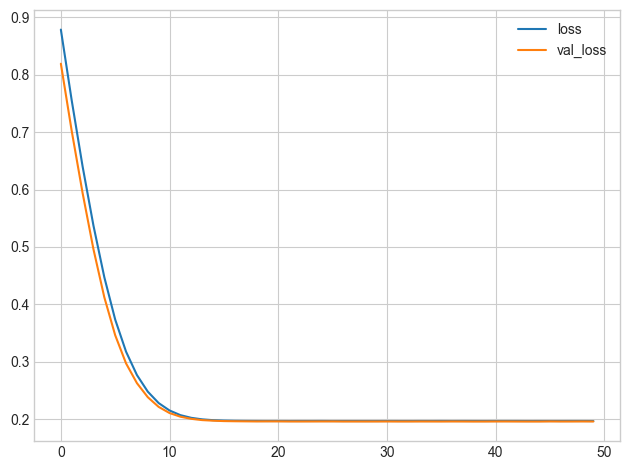

In [5]:
model = keras.Sequential([
    layers.Dense(1, input_shape=input_shape),
])
model.compile(
    optimizer='adam',
    loss='mae',
)
history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=512,
    epochs=50,
    verbose=0, # suppress output since we'll plot the curves
)
history_df = pd.DataFrame(history.history)
history_df.loc[0:, ['loss', 'val_loss']].plot()
print("Minimum Validation Loss: {:0.4f}".format(history_df['val_loss'].min()));

Nije neuobičajeno da krivulje slijede uzorak "hokejaške palice" kao što vidite ovdje. Zbog toga je završni dio treninga teško vidljiv, pa umjesto toga počnimo od epohe 10:

Minimum Validation Loss: 0.1958


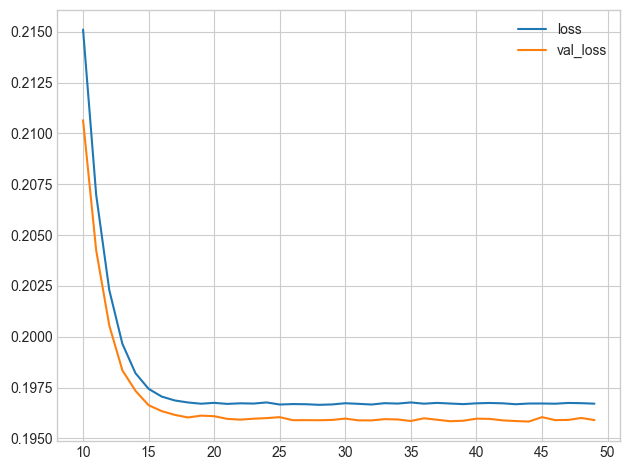

In [7]:
# Start the plot at epoch 10
history_df.loc[10:, ['loss', 'val_loss']].plot()
print("Minimum Validation Loss: {:0.4f}".format(history_df['val_loss'].min()));

# 1) Procijenite osnovnu liniju

Što misliš? Biste li rekli da je ovaj model underfitting, overfitting, ili baš kako treba?

Sada dodajmo malo kapaciteta našoj mreži. Dodat ćemo tri skrivena sloja sa po 128 jedinica. Pokrenite sljedeću ćeliju da uvježbate mrežu i vidite krivulje učenja.

c:\Users\ASUS\Desktop\PSU-lab\Lab3_online\psu\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - loss: 0.2485 - val_loss: 0.2044
Epoch 2/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2017 - val_loss: 0.1985
Epoch 3/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.1954 - val_loss: 0.1969
Epoch 4/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1917 - val_loss: 0.1968
Epoch 5/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1907 - val_loss: 0.1968
Epoch 6/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1883 - val_loss: 0.1959
Epoch 7/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.1856 - val_loss: 0.1964
Epoch 8/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1866 - val_loss: 0.1968
Epoch 9/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1853 - val_loss: 0.1957
Epoch 10/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1824 - val_loss: 0.1958
Epoch 11/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1827 - val_loss: 0.1953
Epoch 12/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.1826 - val_

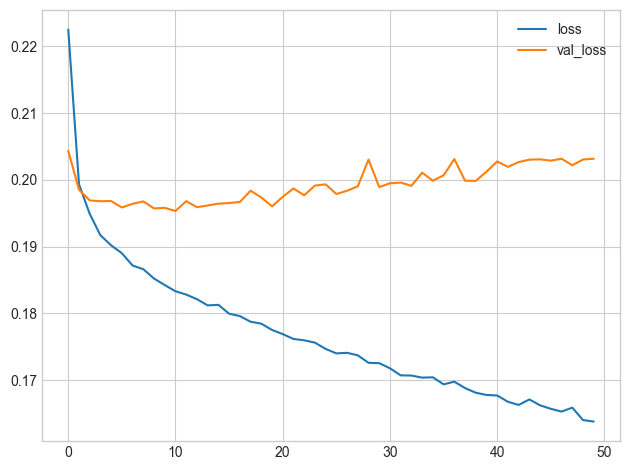

In [8]:
model = keras.Sequential([
    layers.Dense(128, activation='relu', input_shape=input_shape),
    layers.Dense(64, activation='relu', input_shape=input_shape),
    layers.Dense(1)
])
model.compile(
    optimizer='adam',
    loss='mae',
)
history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=512,
    epochs=50,
)
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()
print("Minimum Validation Loss: {:0.4f}".format(history_df['val_loss'].min()));

# 2) Dodajte kapacitet

Kakva je vaša ocjena ovih krivulja? underfitting, overfitting, baš kako treba?

# 3) Definirajte rano zaustavljanje povratnog poziva

Sada definirajte povratni poziv ranog zaustavljanja koji čeka 5 epoha (`patience`) za promjenu u gubitku valjanosti od najmanje `0,001` (`min_delta`) i zadržava težine s najboljim gubitkom (`restore_best_weights`).

In [10]:
from tensorflow.keras import callbacks

# YOUR CODE HERE: define an early stopping callback
early_stopping = callbacks.EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=5, # how many epochs to wait before stopping
    restore_best_weights=True,
)

Sada pokrenite ovu ćeliju da uvježbate model i dobijete krivulje učenja. Obratite pažnju na argument `callbacks` u `model.fit`.

Epoch 1/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 0.2964 - val_loss: 0.2037
Epoch 2/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.2030 - val_loss: 0.1998
Epoch 3/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.1960 - val_loss: 0.1978
Epoch 4/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1931 - val_loss: 0.1969
Epoch 5/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1902 - val_loss: 0.1969
Epoch 6/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1895 - val_loss: 0.1961
Epoch 7/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1901 - val_loss: 0.1948
Epoch 8/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.1870 - val_loss: 0.1955
Epoch 9/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.1853 - val_loss: 0.1947
Epoch 10/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1854 - val_loss: 0.1955
Epoch 11/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1860 - val_loss: 0.1961
Epoch 12/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1851 - val_

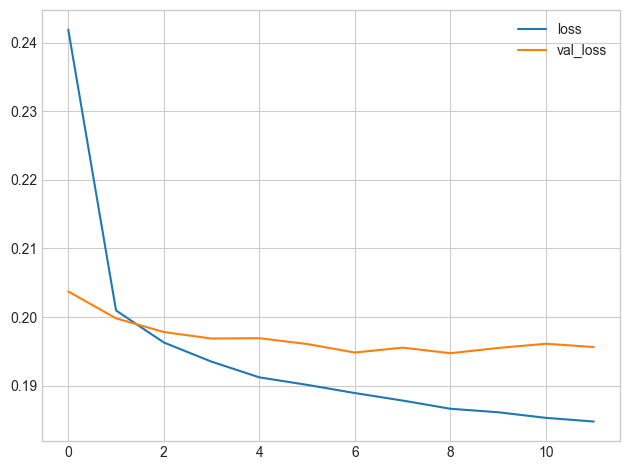

In [11]:
model = keras.Sequential([
    layers.Dense(128, activation='relu', input_shape=input_shape),
    layers.Dense(64, activation='relu'),    
    layers.Dense(1)
])
model.compile(
    optimizer='adam',
    loss='mae',
)
history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=512,
    epochs=50,
    callbacks=[early_stopping]
)
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()
print("Minimum Validation Loss: {:0.4f}".format(history_df['val_loss'].min()));

# 4) Uvježbavanje i tumačenje

Je li to bilo poboljšanje u usporedbi s treningom bez ranog prekida?

Ako želite, pokušajte eksperimentirati s `patience` i `min_delta` da vidite kakvu bi razliku moglo napraviti.

# Nastavi #

Prijeđite na [**sljedeću vježbu**](Dropout_and_Batch_Normalization_hr.ipynb): batch normalization i dropout.